In [1]:
import pandas as pd
import numpy as np
from pandas import DataFrame
from datetime import datetime,date,timedelta
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import os

In [2]:
#Input Working directory or directory you want to work in
dirname=input("Enter the current working directory")
os.chdir(dirname)# Set current working directory
os.getcwd() # Get current working directory


Enter the current working directory/Users/shivamgoel/Desktop/Python/final


'/Users/shivamgoel/Desktop/Python/final'

In [3]:
airlines_data = pd.read_csv('data/airlines.csv',low_memory=False,error_bad_lines=False,warn_bad_lines=False, skipinitialspace=True)
airports_data = pd.read_csv('data/airports.csv',low_memory=False,error_bad_lines=False,warn_bad_lines=False, skipinitialspace=True)
flights = pd.read_csv('data/flights.csv',low_memory=False,error_bad_lines=False,warn_bad_lines=False, skipinitialspace=True,
                           na_values=['NA      ', 'NA    ', 'NA   ', 'NA', 'NA ', 'NA ', 'NaN', 'NAN', ''])

In [10]:
#Shapping Data
airlines_data.shape[0] #no of rows=14
airlines_data.shape[1] #no of columns=2

airports_data.shape[0] #no of rows=322
airports_data.shape[1] #no of columns=7

flights.shape[0] #no of rows = 5819079
flights.shape[1] #no of columns = 31
airports_data.head()

,IATA_CODE,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE
0,ABE,Lehigh Valley International Airport,Allentown,PA,USA,40.65236,-75.44040
1,ABI,Abilene Regional Airport,Abilene,TX,USA,32.41132,-99.68190
2,ABQ,Albuquerque International Sunport,Albuquerque,NM,USA,35.04022,-106.60919
3,ABR,Aberdeen Regional Airport,Aberdeen,SD,USA,45.44906,-98.42183
4,ABY,Southwest Georgia Regional Airport,Albany,GA,USA,31.53552,-84.19447


In [5]:
unique_flights_data = {}
for item in flights.columns:
    unique_flights_data[item] = flights[item].unique()
#unique_flights_data

In [6]:
day_of_week_desc={
    1:'Monday',
    2:'Tuesday',
    3:'Wednesday',
    4:'Thursday',
    5:'Friday',
    6:'Saturday',
    7:'Sunday'
}
flights['DESC_DOW']=flights['DAY_OF_WEEK'].apply(lambda a:day_of_week_desc[a])


In [7]:
airlines_dict = dict(zip(airlines_data['IATA_CODE'],airlines_data['AIRLINE']))
airport_dict = dict(zip(airports_data['IATA_CODE'],airports_data['AIRPORT']))
flights['DESC_AIRLINE'] = flights['AIRLINE'].apply(lambda x: airlines_dict[x])
flights.head()['DESC_AIRLINE']

0      Alaska Airlines Inc.
1    American Airlines Inc.
2           US Airways Inc.
3    American Airlines Inc.
4      Alaska Airlines Inc.
Name: DESC_AIRLINE, dtype: object

# Where in the USA are the worst weather delays that affect my flights?

In [11]:
#Renaming Data Frame column
flights.rename(columns={'ORIGIN_AIRPORT' : 'IATA_CODE'}, inplace=True)


In [12]:
#Merging Airport and Airlines based on common origin airport
dfMaster = pd.merge(flights,airports_data , on='IATA_CODE', how = 'inner')

In [13]:
data_weather=dfMaster[dfMaster.WEATHER_DELAY > 0]
data_weather = data_weather.reset_index(drop=True)
data_weather.head()
data_weather_orgin = data_weather[['WEATHER_DELAY', 'LATITUDE', 'LONGITUDE']].copy()


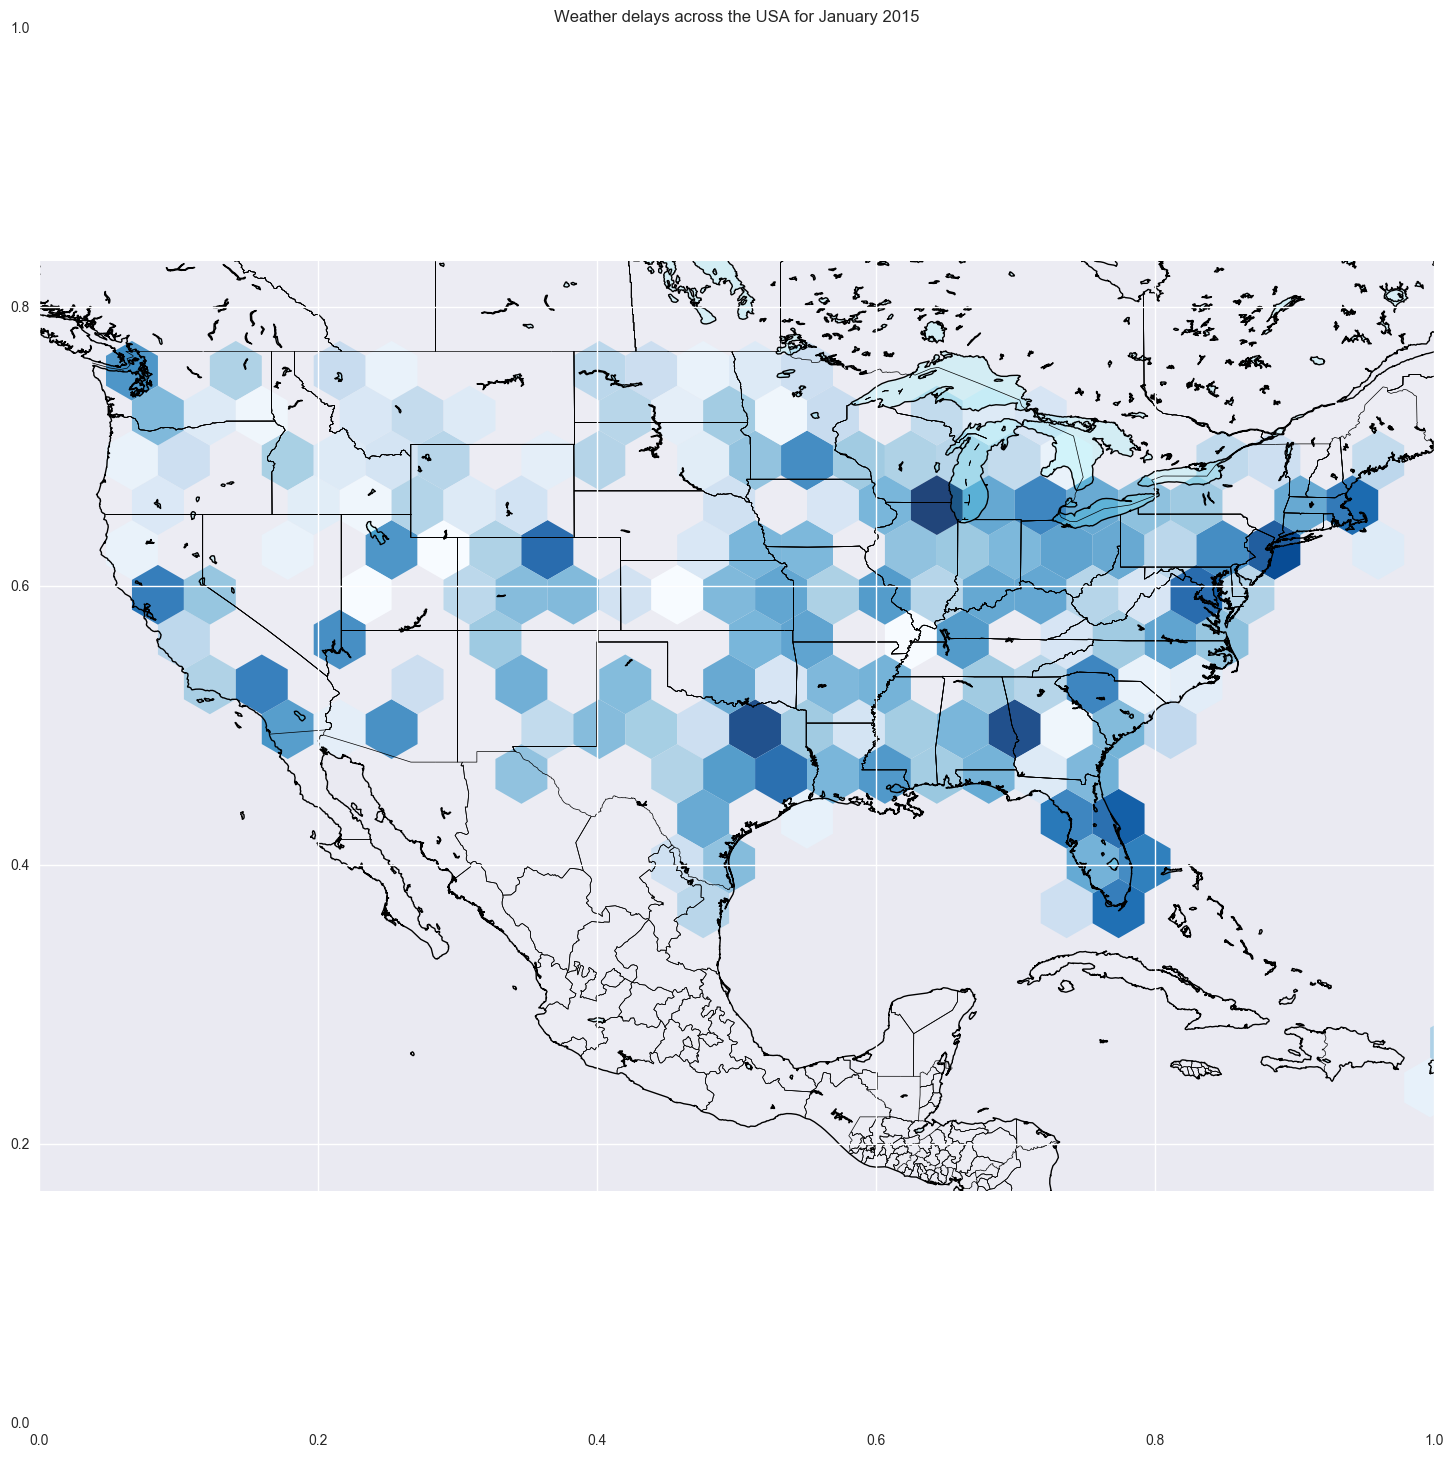

In [15]:
from numpy.random import uniform
from mpl_toolkits.basemap import Basemap
from matplotlib.colors import LinearSegmentedColormap


def plot_hex_delays(df_in):
    longitude =-97.0372
    latitude= 32.895951

    figure, axes = plt.subplots(nrows=1, ncols=1, figsize=(18, 18))

    m = Basemap(
                    ax=axes,
                    projection='cyl',
                    lon_0=-97.0372, lat_0=32.895951,
                    llcrnrlat=latitude - 20.0, urcrnrlat=latitude + 20.0,
                    llcrnrlon=longitude - 30.0, urcrnrlon=longitude + 30.0,
                    resolution='i'
                    )

    m.fillcontinents(color='white', alpha = 0.1,lake_color='aqua')

    m.drawcoastlines()
    m.drawstates()
    m.drawcountries()
    m.drawstates()
    
    figwidth = 14

    ax = figure.add_subplot(111, axisbg='w', frame_on=False)

    # The number of hexbins you want in the x-direction
    numhexbins = 50
    hx = m.hexbin(
        np.array([x for x in df_in.LONGITUDE]),
        np.array([y for y in df_in.LATITUDE]),
        gridsize=(numhexbins, int(numhexbins*0.3)), #critical to get regular hexagon, must stretch to map dimensions
        bins='log', mincnt=1, edgecolor='none', alpha=1.,
        cmap=plt.get_cmap('Blues'))
 
    plt.title('Weather delays across the USA for January 2015')
    plt.savefig('Flights_Fig8.png', dpi=300, bbox_inches="tight")
    plt.show()
    
    
plot_hex_delays(data_weather_orgin)